# Correlations

##### Keywords: correlation, covariance, multivariate normal, LKJ Prior

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

## A gaussian with correlations

We wish to sample a 2D Posterior which looks something like below. Here the x and y axes are parameters.

<function matplotlib.pyplot.xlim>

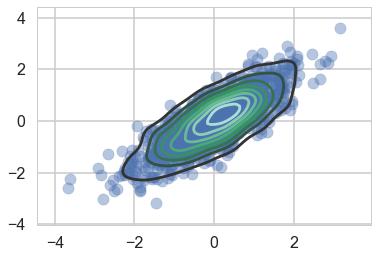

In [2]:
cov=np.array([[1,0.8],[0.8,1]])
data = np.random.multivariate_normal([0,0], cov, size=1000)
sns.kdeplot(data);
plt.scatter(data[:,0], data[:,1], alpha=0.4)
plt.xlim

To model a covariance, consider that in can be written thus:

![](images/cov1.png)

which can then be written as:

![](images/cov2.png)

Where $R$ is a correlation matrix (with 1's down its diagonal)

In [3]:
import theano.tensor as tt
def pm_make_cov(sigpriors, corr_coeffs, ndim):
    sigma_matrix = tt.nlinalg.diag(sigpriors)
    n_elem = int(ndim * (ndim - 1) / 2)
    tri_index = np.zeros([ndim, ndim], dtype=int)
    tri_index[np.triu_indices(ndim, k=1)] = np.arange(n_elem)
    tri_index[np.triu_indices(ndim, k=1)[::-1]] = np.arange(n_elem)
    corr_matrix = corr_coeffs[tri_index]
    corr_matrix = tt.fill_diagonal(corr_matrix, 1)
    return tt.nlinalg.matrix_dot(sigma_matrix, corr_matrix, sigma_matrix)

### Matrixy indexing

In [19]:
tri_index = np.zeros([3, 3], dtype=int)
tri_index

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [20]:
tri_index[np.triu_indices(3, k=1)] = np.arange(3)
print(tri_index)
tri_index[np.triu_indices(3, k=1)[::-1]] = np.arange(3)

print(tri_index)



[[0 0 1]
 [0 0 2]
 [0 0 0]]
[[0 0 1]
 [0 0 2]
 [1 2 0]]


In [21]:
test=np.array([5,6,7])
test[tri_index]

array([[5, 5, 6],
       [5, 5, 7],
       [6, 7, 5]])

## The LKJ prior for sampling

Our correlation matrices need a prior. In the 2-D case they looklike

```
1 rho
rho 1
```

In a linear regression scenario, you can think of `rho` as a correlation between the intercept and the slope. Here there is just one parameter to create a prior for. Of-course in larger models, with more intercepts and slopes..think hierarchical models here...there is more than one `rho`.

The prior we use for this is the [LKJ prior](https://www.sciencedirect.com/science/article/pii/S0047259X09000876)

In [46]:
eta1 = pm.LKJCorr.dist(eta=1, n=2).random(size=10000).flatten()
eta3 = pm.LKJCorr.dist(eta=3, n=2).random(size=10000).flatten()
eta5 = pm.LKJCorr.dist(eta=5, n=2).random(size=10000).flatten()
eta10 = pm.LKJCorr.dist(eta=10, n=2).random(size=10000).flatten()

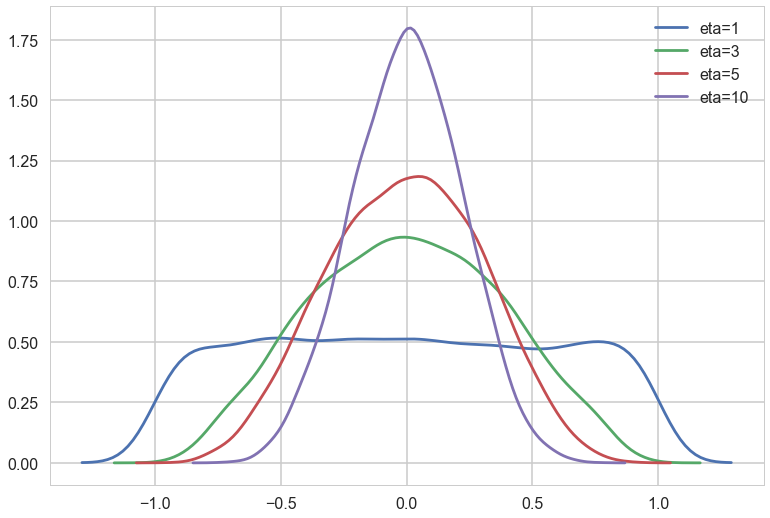

In [47]:
with sns.plotting_context('poster'):
    sns.kdeplot(eta1, label='eta=1')
    sns.kdeplot(eta3, label='eta=3')
    sns.kdeplot(eta5, label='eta=5')
    sns.kdeplot(eta10, label='eta=10')
    plt.legend();

Notice $\eta=1$ is almost uniform in correlation while higher values penalize extreme correlations.

Why use this prior? The standard prior for MVN covariances used to be the inverse wishart prior. Howerver that prior has much heavier tails and tends to put too much weight on extreme correlations.

In [16]:
sigs=np.array([1,1])

In [7]:
with pm.Model() as modelmvg: 
    nu = pm.Uniform('nu', 1, 5)  # prior on how much correlation (0 = uniform prior on correlation, oo = no correlation)
    ndim=2
    corr_coeffs = pm.LKJCorr('corr_coeffs', nu, ndim) 
    cov = pm_make_cov(sigs, corr_coeffs, ndim)
    mvg = pm.MvNormal('mvg', mu=[0,0], cov=cov, shape=2, observed=data)

In [8]:
with modelmvg:
    nutstrace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [corr_coeffs_interval__, nu_interval__]
100%|██████████| 10500/10500 [01:15<00:00, 139.89it/s]


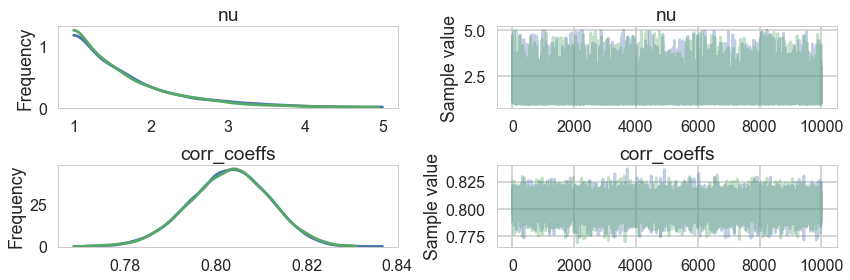

In [9]:
pm.traceplot(nutstrace);

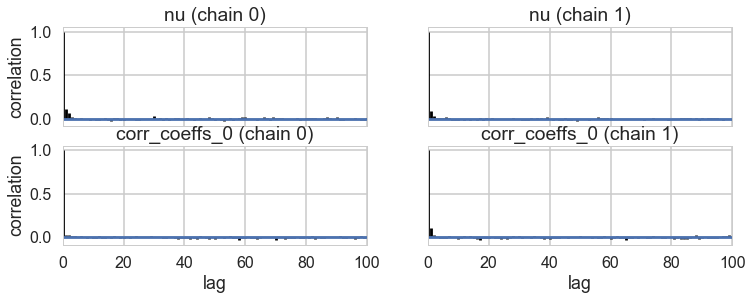

In [10]:
pm.autocorrplot(nutstrace);

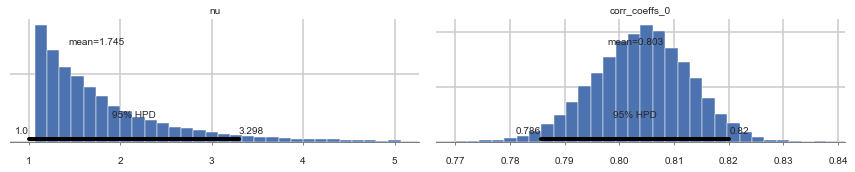

In [11]:
pm.plot_posterior(nutstrace);

In [26]:
with pm.Model() as modelmvg2: 
    nu = pm.Uniform('nu', 1, 5)  # prior on how much correlation (0 = uniform prior on correlation, oo = no correlation)
    ndim=2
    #sigs=np.array([1,1])
    #sigs = pm.Lognormal('sigma', np.zeros(2), np.ones(2), shape=2)
    sigs=tt.stack([pm.Lognormal("sigma_{}".format(i), 0, 1) for i in [0,1]])
    corr_coeffs = pm.LKJCorr('corr_coeffs', nu, ndim) 
    cov = pm_make_cov(sigs, corr_coeffs, ndim)
    mvg = pm.MvNormal('mvg', mu=[0,0], cov=cov, shape=2, observed=data)

In [28]:
with modelmvg2:
    nutstrace2 = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [corr_coeffs_interval__, sigma_1_log__, sigma_0_log__, nu_interval__]
100%|██████████| 10500/10500 [02:17<00:00, 76.38it/s]


In [29]:
pm.summary(nutstrace2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
nu,1.728708,0.714573,0.005871,1.000011,3.231310,16474.0,0.999988
sigma_0,0.996188,0.022471,0.000249,0.953082,1.041426,9278.0,1.000039
sigma_1,1.030485,0.023077,0.000235,0.986373,1.076912,9360.0,1.000101
corr_coeffs__0,0.807465,0.011077,0.000118,0.784844,0.828079,10351.0,0.999957


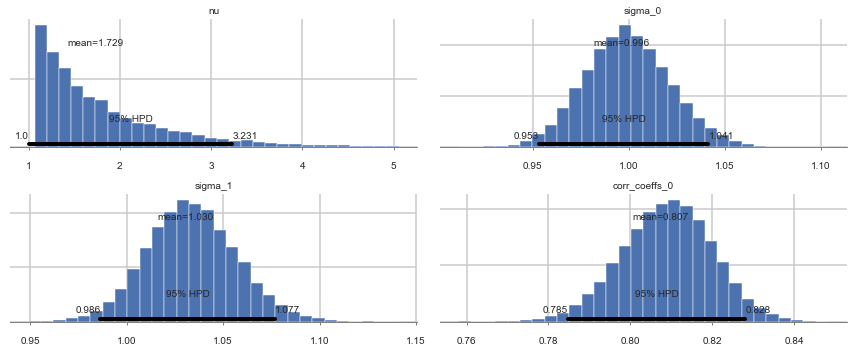

In [30]:
pm.plot_posterior(nutstrace2);

## Prior-ing the Cholesky Decomposition

In [49]:
with pm.Model() as modelmvg3: 
    nu = pm.Uniform('nu', 1, 5)  # prior on how much correlation (0 = uniform prior on correlation, oo = no correlation)
    ndim=2
    packed_L = pm.LKJCholeskyCov('packed_L', n=ndim,
                                 eta=nu, sd_dist=pm.Lognormal.dist(0,1))
    L = pm.expand_packed_triangular(2, packed_L)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    mvg = pm.MvNormal('mvg', mu=[0,0], chol=L, observed=data)

In [50]:
with modelmvg3:
    nutstrace3 = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [packed_L_cholesky_cov_packed__, nu_interval__]
100%|██████████| 10500/10500 [01:14<00:00, 141.44it/s]


In [51]:
pm.summary(nutstrace3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
nu,1.729066,0.712922,0.005749,1.000079,3.244691,17507.0,1.000000
packed_L__0,0.995574,0.022501,0.000188,0.953160,1.040111,12362.0,1.000100
packed_L__1,0.831761,0.027127,0.000225,0.779986,0.885996,11845.0,1.000104
packed_L__2,0.607402,0.013493,0.000118,0.581064,0.633993,16691.0,1.000175
Sigma__0_0,0.991673,0.044852,0.000375,0.908514,1.081831,12337.0,1.000103
Sigma__0_1,0.828508,0.042360,0.000368,0.747981,0.913586,10934.0,1.000133
Sigma__1_0,0.828508,0.042360,0.000368,0.747981,0.913586,10934.0,1.000133
Sigma__1_1,1.061681,0.048111,0.000399,0.969422,1.156746,12252.0,1.000238


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b5132e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12b89a940>]], dtype=object)

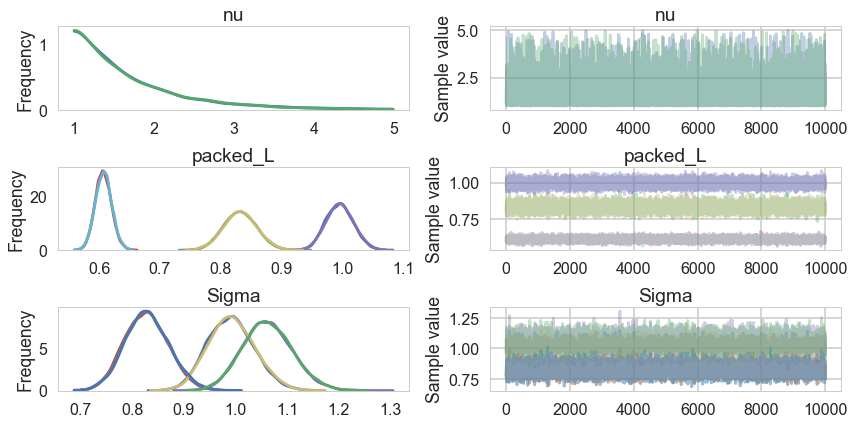

In [52]:
pm.traceplot(nutstrace3)

Why is this parametrization useful? You will recall from the Gelman schools that we converted a sampler $N(\mu, \sigma) = \mu + \sigma\nu$ where $\nu \sim N(0,1)$. This is the "non-centered" parametrization, and it reduced one layer in the hierarchical model, thus reducing curvature. Helped us produce a different sampler.

The main place we want to model correlations is in **Varying Effects** models, where we hierarchically float both intercept and slope. For example, in our prosocial chimps model we have so far used hiearchcal intercepts for both "actor" and "block", resulting in a cross-correlated model. What if we let there be block and actor specific slopes for both the prosocial-left option and the condition:

![](images/pchimps3.png)

We assume a correlated model for these:

![](images/pchimps4.png)

If you do this you will get the usual "divergences" warnings from pymc3, and will want to use a non-centered parametrization:

![](images/pchimps5.png)

We are assuming 0 mean priors here. This parametrization now makes the priors possibly correlates z-scores. So the next thing we do is to model the correlation, and furthermore, we can do it with the Cholesky Matrix $L$.

Each step will give us faster samplers.